In [ ]:
import torch
from torch import Tensor
print(torch.__version__)
import pandas as pd

2.0.1+cu118


In [ ]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 24.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 36.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.3 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-dnokrdy4
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-dnokrdy4
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit bc69d1ace586c06983e4acc682b385b330759d2e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-any.whl

In [ ]:
import pandas as pd
import json
import torch
from torch import Tensor
print(torch.__version__)
import os
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader
import tqdm
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.data import NeighborSampler
import torch_geometric

2.0.1+cu118


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="drive/My Drive"

In [ ]:
import json

# Define the file path for the downloaded JSON file
json_file_path = path+"/mem_event_data.json"

# Read the JSON data
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Print the JSON data
len(data)

125927

In [ ]:
import random

# Convert the dictionary to a list of key-value pairs
data_list = list(data.items())

# Shuffle the list in random order
random.shuffle(data_list)

# Calculate the split point for 80% training data
split_point = int(0.8 * len(data_list))

# Create separate lists for training and testing data
train_data_list = data_list[:split_point]
test_data_list = data_list[split_point:]

# Convert the lists back to dictionaries
train_data_dict = dict(train_data_list)
test_data_dict = dict(test_data_list)

#print("Training data dictionary:")
print(len(train_data_dict))
#print("\nTesting data dictionary:")
print(len(test_data_dict))

100741
25186


In [ ]:
# Convert the dictionary to a list of tuples
data_list = [(k, v) for k, v in train_data_dict.items()]

In [ ]:
df = pd.DataFrame(data_list, columns=['Key', 'Values'])
df

,Key,Values
0,211465138,[233043016]
1,189747498,"[224913683, 227270161, qjgbljytmbkc, 225451273..."
2,137879022,"[dfdvhhysgbfb, drjswhysqbqb, qlgjkkysqbdb, dfd..."
3,198380320,"[227596924, 228262356]"
4,118891832,"[nkkcglytgbmb, nkkcglytgbvb, kbzbglytgbcc, kbz..."
...,...,...
100736,136532852,"[178718052, 221790426, 198550822, 213302422, 2..."
100737,28466752,"[229109065, 224704143, dgnsglytlblc, 228763806..."
100738,195135129,"[229424675, 231692758]"
100739,209696321,[232992622]


In [ ]:
df["Key"].nunique()

100741

In [ ]:
new_column_names = {"Key": 'user', "Values": 'event'}
df = df.rename(columns=new_column_names)
df

,user,event
0,211465138,[233043016]
1,189747498,"[224913683, 227270161, qjgbljytmbkc, 225451273..."
2,137879022,"[dfdvhhysgbfb, drjswhysqbqb, qlgjkkysqbdb, dfd..."
3,198380320,"[227596924, 228262356]"
4,118891832,"[nkkcglytgbmb, nkkcglytgbvb, kbzbglytgbcc, kbz..."
...,...,...
100736,136532852,"[178718052, 221790426, 198550822, 213302422, 2..."
100737,28466752,"[229109065, 224704143, dgnsglytlblc, 228763806..."
100738,195135129,"[229424675, 231692758]"
100739,209696321,[232992622]


In [ ]:
# Convert the dictionary into a list of tuples
# Create the DataFrame
df = df.explode("event")

# Display the DataFrame
print(df)

             user         event
0       211465138     233043016
1       189747498     224913683
1       189747498     227270161
1       189747498  qjgbljytmbkc
1       189747498     225451273
...           ...           ...
100740  202465937     234505848
100740  202465937     233666525
100740  202465937     231601825
100740  202465937     231873964
100740  202465937     232068764

[1521150 rows x 2 columns]


In [ ]:
# Remove rows where 'Left' and 'Right' elements are the same
df.drop_duplicates(subset=['user', 'event'], keep=False,inplace=True)
df.head()

,user,event
0,211465138,233043016
1,189747498,224913683
1,189747498,227270161
1,189747498,qjgbljytmbkc
1,189747498,225451273


In [ ]:
# Reset the index
df.reset_index(drop=True, inplace=True)
df

,user,event
0,211465138,233043016
1,189747498,224913683
2,189747498,227270161
3,189747498,qjgbljytmbkc
4,189747498,225451273
...,...,...
1521145,202465937,234505848
1521146,202465937,233666525
1521147,202465937,231601825
1521148,202465937,231873964


In [ ]:
# Define the file path for the downloaded JSON file
json_file_path = path+"/event_data.json"

# # Read the JSON data
# with open(json_file_path, 'r') as file:
#     data = json.load(file)
# Read the JSON file with feature vectors
with open(json_file_path, 'r') as f:
    feature_vectors_event = json.load(f)

# Define the file path for the downloaded JSON file
json_file_path = path+"/mem_final_data.json"
with open(json_file_path, 'r') as f:
    feature_vectors_mem = json.load(f)
# Create a dictionary to store the node features
node_features_event = {}
node_features_mem = {}

In [ ]:
default_member_feature = [0.0] * 500  # Replace num_features_member with the actual dimension of member feature vectors
default_event_feature = [0.0] * 500
for i in df["user"].unique():
    node_features_mem[i]=feature_vectors_mem.get(i, default_member_feature)

In [ ]:
for i in df["event"].unique():
    node_features_event[i]=feature_vectors_event.get(i, default_member_feature)

In [ ]:
event_feat= pd.DataFrame(node_features_event)
event_feat=event_feat.T
event_feat

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
233043016,-1.208172,-0.524999,-0.958839,0.401279,0.859632,0.613723,0.032827,-0.211778,0.278032,-0.073995,...,-0.019480,-0.018155,-0.025441,-0.002585,0.033139,-0.020671,-0.017649,-0.015643,-0.024912,-0.029561
224913683,-0.517896,1.316646,1.990788,1.380921,-0.875965,0.502652,0.365506,-1.226163,-0.722907,0.014127,...,0.052190,0.022802,-0.046164,0.011538,0.030403,0.019036,-0.009712,0.010932,0.006837,0.050051
227270161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
qjgbljytmbkc,-1.420580,-0.729892,-1.592516,0.913243,1.810226,1.365993,-0.061373,-0.521411,0.742618,-0.135708,...,-0.026748,-0.228273,-0.106790,-0.255389,0.793194,-0.229442,0.331052,-0.920948,0.079806,-0.166382
225451273,0.414555,4.094225,-1.484655,-3.102376,0.178089,-2.042861,0.708548,-0.611657,0.366522,0.066477,...,-0.032102,0.016159,-0.011338,-0.064664,-0.018447,0.055559,-0.022121,-0.096351,0.008546,0.066795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168780932,-0.610943,-1.611548,-2.332916,1.180778,-0.279252,-0.051446,0.052368,0.147960,0.069946,-0.168817,...,-0.009936,0.001543,-0.014369,0.023769,0.020534,-0.012761,-0.027145,-0.003185,-0.021917,-0.028774
222665147,-1.364288,-0.522315,-1.236563,0.735861,0.268408,0.181421,-0.275019,-0.066215,0.159294,0.078968,...,-0.001518,0.005150,0.006355,0.016764,-0.008183,-0.013069,-0.015799,-0.012343,0.013520,-0.003193
228623470,0.400417,-1.311382,0.455123,-1.533180,2.286315,0.783372,1.529627,0.330571,-0.489283,0.058586,...,-0.072663,-1.057007,1.443063,-5.959161,0.551672,2.312828,1.034512,-3.067645,-2.466942,-0.016944
37525622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
event_feat = torch.from_numpy(event_feat.values).to(torch.float)
event_feat

tensor([[-1.2082, -0.5250, -0.9588,  ..., -0.0156, -0.0249, -0.0296],
        [-0.5179,  1.3166,  1.9908,  ...,  0.0109,  0.0068,  0.0501],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.4004, -1.3114,  0.4551,  ..., -3.0676, -2.4669, -0.0169],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
member_feat= pd.DataFrame(node_features_mem)
member_feat=member_feat.T
member_feat

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
211465138,-3.279718,-1.581408,-0.537926,0.409094,-0.124420,-0.049622,0.331259,-0.269786,0.094830,0.192397,...,0.025530,-0.004218,0.074689,-0.043836,-0.067123,-0.033869,0.094691,-0.040751,0.036591,0.057159
189747498,-3.048261,-1.401971,-0.439379,0.332434,-0.099182,-0.039446,0.260741,-0.208206,0.072277,0.145391,...,-0.035189,-0.005795,-0.067700,0.038023,0.078892,0.039298,-0.093657,0.029777,-0.030939,-0.059367
137879022,1.445383,1.277879,7.894150,1.673000,-5.523442,-4.014568,1.077873,2.458532,-0.403432,-0.161801,...,-1.575093,-2.260196,-0.468293,0.506565,-0.590753,0.613538,0.140866,0.316611,0.111811,1.647466
198380320,-3.279718,-1.581408,-0.537926,0.409094,-0.124420,-0.049622,0.331259,-0.269786,0.094830,0.192397,...,0.025530,-0.004218,0.074689,-0.043836,-0.067123,-0.033869,0.094691,-0.040751,0.036591,0.057159
118891832,-3.279718,-1.581408,-0.537926,0.409094,-0.124420,-0.049622,0.331259,-0.269786,0.094830,0.192397,...,0.025530,-0.004218,0.074689,-0.043836,-0.067123,-0.033869,0.094691,-0.040751,0.036591,0.057159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136532852,-3.669106,4.086245,-0.310242,-0.072372,0.035845,0.002456,-2.249579,-2.212088,-0.335665,1.225827,...,0.140258,-0.208714,0.048704,0.193495,-0.148152,-0.133755,-0.078878,-0.011006,0.270081,0.055457
28466752,4.287375,12.828595,7.090140,-1.313185,-9.543055,-6.300763,-4.850005,0.015929,-0.653754,-0.107156,...,-0.369336,-0.820157,0.274728,0.047406,0.036283,0.628615,0.486836,0.416320,-1.036163,-1.299601
195135129,-1.231663,-1.494455,0.968352,-0.035718,-0.090491,2.383185,-0.144459,-0.075106,-0.921826,-0.209538,...,-0.980978,-0.320279,-1.825984,1.080939,-0.835743,-1.586825,-1.049239,0.410410,-0.150535,-0.434096
209696321,-2.692043,0.451722,-0.434056,0.834997,-0.731611,-0.056231,1.008947,0.060368,-0.130763,0.280960,...,-0.064730,-0.526735,0.781538,0.456374,-0.119247,0.208204,-0.301527,0.515790,-0.000098,-0.213644


In [ ]:
member_feat = torch.from_numpy(member_feat.values).to(torch.float)
member_feat

tensor([[-3.2797e+00, -1.5814e+00, -5.3793e-01,  ..., -4.0751e-02,
          3.6591e-02,  5.7159e-02],
        [-3.0483e+00, -1.4020e+00, -4.3938e-01,  ...,  2.9777e-02,
         -3.0939e-02, -5.9367e-02],
        [ 1.4454e+00,  1.2779e+00,  7.8941e+00,  ...,  3.1661e-01,
          1.1181e-01,  1.6475e+00],
        ...,
        [-1.2317e+00, -1.4945e+00,  9.6835e-01,  ...,  4.1041e-01,
         -1.5054e-01, -4.3410e-01],
        [-2.6920e+00,  4.5172e-01, -4.3406e-01,  ...,  5.1579e-01,
         -9.7626e-05, -2.1364e-01],
        [ 1.0234e+01, -5.9913e-01, -9.8250e-01,  ..., -7.8094e-01,
          8.2320e-01,  2.6310e-01]])

In [ ]:
# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = df['user'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()

Mapping of user IDs to consecutive values:
      userId  mappedID
0  211465138         0
1  189747498         1
2  137879022         2
3  198380320         3
4  118891832         4



In [ ]:
# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(df['user'], unique_user_id,
                            left_on='user', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_user_id

tensor([     0,      1,      1,  ..., 100740, 100740, 100740])

In [ ]:
# Create a mapping from unique event indices to range [0, num_movie_nodes):
unique_event_id= df['event'].unique()
unique_event_id = pd.DataFrame(data={
    'eventId': unique_event_id,
    'mappedID': pd.RangeIndex(len(unique_event_id)),
})
print("Mapping of event IDs to consecutive values:")
print("===========================================")
print(unique_event_id.head())

Mapping of event IDs to consecutive values:
        eventId  mappedID
0     233043016         0
1     224913683         1
2     227270161         2
3  qjgbljytmbkc         3
4     225451273         4


In [ ]:

ratings_movie_id = pd.merge(df['event'], unique_event_id,
                            left_on='event', right_on='eventId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)

# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_event = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
#assert edge_index_user_to_movie.size() == (2, 100836)

print(ratings_movie_id)
print("Final edge indices pointing from users to events:")
print("=================================================")
print(edge_index_user_to_event)

tensor([    0,     1,     2,  ..., 51393, 11789, 85285])
Final edge indices pointing from users to events:
tensor([[     0,      1,      1,  ..., 100740, 100740, 100740],
        [     0,      1,      2,  ...,  51393,  11789,  85285]])


In [ ]:
len(edge_index_user_to_event[0])

1521150

In [ ]:
len(df['event'])

1521150

In [ ]:
df['event'].nunique()

349892

In [ ]:
data = HeteroData()

# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["event"].node_id = torch.arange(len(df['event'].unique()))

In [ ]:
# Add the node features and edge indices:
data["event"].x = event_feat

data["user"].x = member_feat
data["user", "attend", "event"].edge_index = edge_index_user_to_event  # TODO

# We also need to make sure to add the reverse edges from event to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

#raise NotImplementedError

print(data)

HeteroData(
  user={
    node_id=[100741],
    x=[100741, 500],
  },
  event={
    node_id=[349892],
    x=[349892, 500],
  },
  (user, attend, event)={ edge_index=[2, 1521150] },
  (event, rev_attend, user)={ edge_index=[2, 1521150] }
)


## Defining Edge-level Training Splits

In [ ]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
transform = T.RandomLinkSplit(
    num_val=0.1,  # TODO
    num_test=0.1,  # TODO
    disjoint_train_ratio=0.3,  # TODO
    neg_sampling_ratio=2.0,  # TODO
    add_negative_train_samples=False,  # TODO
    edge_types=("user", "attend", "event"),
    rev_edge_types=("event", "rev_attend", "user"),
)
train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)
print(train_data["user", "attend", "event"].edge_label_index.size(1))
print(train_data["user", "attend", "event"].edge_label.min())

Training data:
HeteroData(
  user={
    node_id=[100741],
    x=[100741, 500],
  },
  event={
    node_id=[349892],
    x=[349892, 500],
  },
  (user, attend, event)={
    edge_index=[2, 851844],
    edge_label=[365076],
    edge_label_index=[2, 365076],
  },
  (event, rev_attend, user)={ edge_index=[2, 851844] }
)

Validation data:
HeteroData(
  user={
    node_id=[100741],
    x=[100741, 500],
  },
  event={
    node_id=[349892],
    x=[349892, 500],
  },
  (user, attend, event)={
    edge_index=[2, 1216920],
    edge_label=[456345],
    edge_label_index=[2, 456345],
  },
  (event, rev_attend, user)={ edge_index=[2, 1216920] }
)
365076
tensor(1.)


## Defining Mini-batch Loaders

In [ ]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
#from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["user", "attend", "event"].edge_label_index
edge_label = train_data["user", "attend", "event"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,  # TODO
    num_neighbors=[20,10],  # TODO
    neg_sampling_ratio=2.0,  # TODO
    edge_label_index=(("user", "attend", "event"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

In [ ]:
# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  user={
    node_id=[11272],
    x=[11272, 500],
    n_id=[11272],
    num_sampled_nodes=[3],
  },
  event={
    node_id=[12654],
    x=[12654, 500],
    n_id=[12654],
    num_sampled_nodes=[3],
  },
  (user, attend, event)={
    edge_index=[2, 20155],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[20155],
    num_sampled_edges=[2],
    input_id=[128],
  },
  (event, rev_attend, user)={
    edge_index=[2, 15052],
    e_id=[15052],
    num_sampled_edges=[2],
  }
)


## Creating a Heterogeneous Link-level GNN

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # Define a 2-layer GNN computation graph.
        # Use a *single* `Sigmoid` non-linearity in-between.
        x = F.sigmoid(self.conv1(x, edge_index))
        x = F.sigmoid(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_event: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_event = x_event[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_event).sum(dim=-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and event:
        self.event_lin = torch.nn.Linear(500, hidden_channels)
        self.user_lin = torch.nn.Linear(500, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.event_emb = torch.nn.Embedding(data["event"].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_lin(data["user"].x) + self.user_emb(data["user"].node_id),
          "event": self.event_lin(data["event"].x) + self.event_emb(data["event"].node_id),
        }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)

        pred = self.classifier(
            x_dict["user"],
            x_dict["event"],
            data["user", "attend", "event"].edge_label_index,
        )

        return pred


model = Model(hidden_channels=64)

print(model)

Model(
  (event_lin): Linear(in_features=500, out_features=64, bias=True)
  (user_lin): Linear(in_features=500, out_features=64, bias=True)
  (user_emb): Embedding(100741, 64)
  (event_emb): Embedding(349892, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__attend__event): SAGEConv(64, 64, aggr=mean)
      (event__rev_attend__user): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__attend__event): SAGEConv(64, 64, aggr=mean)
      (event__rev_attend__user): SAGEConv(64, 64, aggr=mean)
    )
    (conv3): ModuleDict(
      (user__attend__event): SAGEConv(64, 64, aggr=mean)
      (event__rev_attend__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


## Training a Heterogeneous Link-level GNN

Device: 'cuda'


100%|██████████| 2853/2853 [02:34<00:00, 18.48it/s]


Epoch: 001, Loss: 0.3564
accuracy: 0.9117


100%|██████████| 2853/2853 [02:33<00:00, 18.63it/s]


Epoch: 002, Loss: 0.2729
accuracy: 0.9482


100%|██████████| 2853/2853 [02:34<00:00, 18.42it/s]


Epoch: 003, Loss: 0.2533
accuracy: 0.9556


100%|██████████| 2853/2853 [02:46<00:00, 17.11it/s]


Epoch: 004, Loss: 0.2431
accuracy: 0.9592


100%|██████████| 2853/2853 [02:35<00:00, 18.30it/s]


Epoch: 005, Loss: 0.2356
accuracy: 0.9618


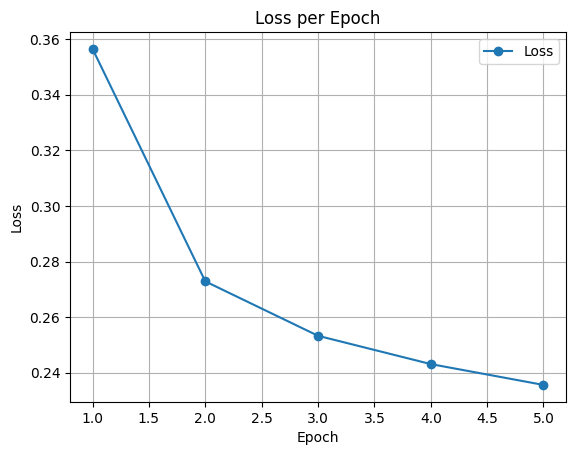

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
history = []
for epoch in range(1, 6):
    total_loss = total_examples = 0
    preds = []
    ground_truths = []
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data = sampled_data.to(device)  # Move `sampled_data` to the respective `device`
        pred = model(sampled_data)  # Run forward pass of the model
        ground_truth = sampled_data["user", "attend", "event"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

        preds.append(pred.detach().cpu())  # Append predictions to the list
        ground_truths.append(ground_truth.detach().cpu())  # Append ground truths to the list

    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")
    history.append(total_loss / total_examples)
    # Concatenate all predictions and ground truths for the entire epoch
    preds = torch.cat(preds, dim=0).numpy()
    ground_truths = torch.cat(ground_truths, dim=0).numpy()

    print(f"accuracy: {roc_auc_score(ground_truths, preds):.4f}")

# Plot the loss graph
epochs = list(range(1, 6))
plt.plot(epochs, history, '-o', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

## Evaluating a Heterogeneous Link-level GNN

In [ ]:
# Define seed edges:
edge_label_index = val_data["user", "attend", "event"].edge_label_index
edge_label = val_data["user", "attend", "event"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,  # TODO
    num_neighbors=[20,10],  # TODO
    neg_sampling_ratio=2.0,  # TODO
    edge_label_index=(("user", "attend", "event"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  user={
    node_id=[13823],
    x=[13823, 500],
    n_id=[13823],
    num_sampled_nodes=[3],
  },
  event={
    node_id=[15114],
    x=[15114, 500],
    n_id=[15114],
    num_sampled_nodes=[3],
  },
  (user, attend, event)={
    edge_index=[2, 26555],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[26555],
    num_sampled_edges=[2],
    input_id=[128],
  },
  (event, rev_attend, user)={
    edge_index=[2, 17891],
    e_id=[17891],
    num_sampled_edges=[2],
  }
)


## On test data

In [ ]:
from numpy import test
edge_label_index = test_data["user", "attend", "event"].edge_label_index
edge_label = test_data["user", "attend", "event"].edge_label

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "attend", "event"), edge_label_index),
    edge_label=edge_label,
    batch_size= 128,
    shuffle=True,
)

sampled_data = next(iter(test_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  user={
    node_id=[5291],
    x=[5291, 500],
    n_id=[5291],
    num_sampled_nodes=[3],
  },
  event={
    node_id=[6287],
    x=[6287, 500],
    n_id=[6287],
    num_sampled_nodes=[3],
  },
  (user, attend, event)={
    edge_index=[2, 8689],
    edge_label=[128],
    edge_label_index=[2, 128],
    e_id=[8689],
    num_sampled_edges=[2],
    input_id=[128],
  },
  (event, rev_attend, user)={
    edge_index=[2, 7091],
    e_id=[7091],
    num_sampled_edges=[2],
  }
)


In [ ]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
      sampled_data.to(device)
      preds.append(model(sampled_data))
      ground_truths.append(sampled_data["user", "attend", "event"].edge_label)
        # TODO: Collect predictions and ground-truths and write them into
        # `preds` and `ground_truths`.
        #raise NotImplementedError

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Test AUC: {auc:.4f}")

100%|██████████| 3566/3566 [01:16<00:00, 46.63it/s]



Test AUC: 0.9585
